In [7]:
import cv2
import os
import matplotlib.pyplot as plt
import numpy as np

In [34]:
video_path = r'AI数据样本\瓷碗出粮（3种粮）+碗内余粮+积粮\1715675377828.mp4'
# video_path = r'钢碗出粮（3种粮）+碗内余粮+积粮\1715676001789.mp4'
capture = cv2.VideoCapture(video_path)

count = 0
frames = []
frame1, frame2 = None, None
while True:
    ret, frame = capture.read()
    count += 1
    if not ret:
        break
    if count % 100 == 0:
        frames.append(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    if count == 100:
        frame1 = frame
    if count == 1200:
        frame2 = frame
    elif count >= 5000:
        break
# frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
frame1 = cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
capture.release()

In [9]:
# cv2.imwrite('test.jpg', cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY))
mask = cv2.cvtColor(frame1, cv2.COLOR_BGR2GRAY)

(640, 368)


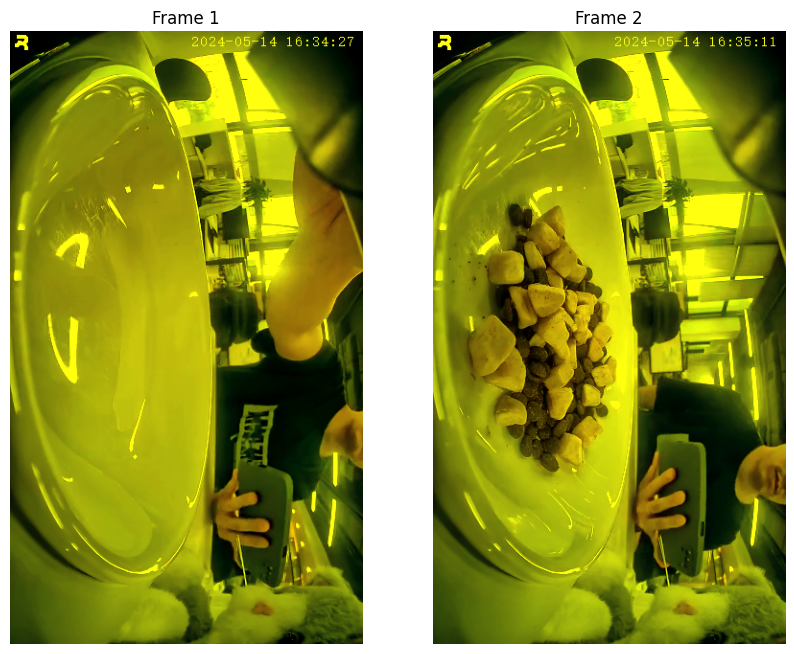

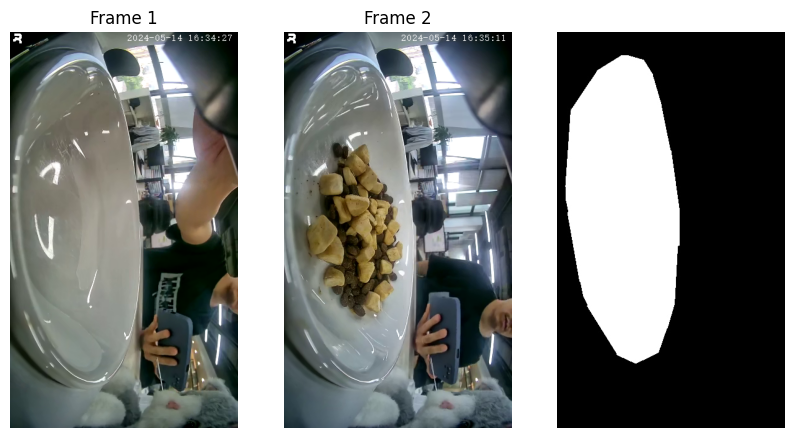

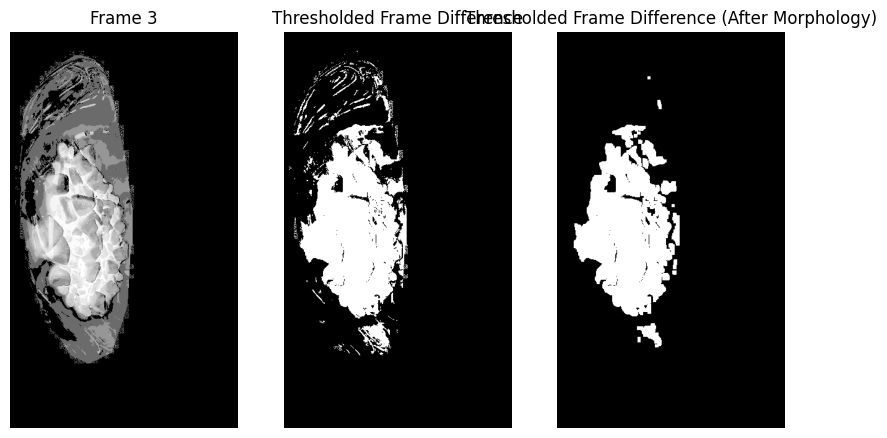

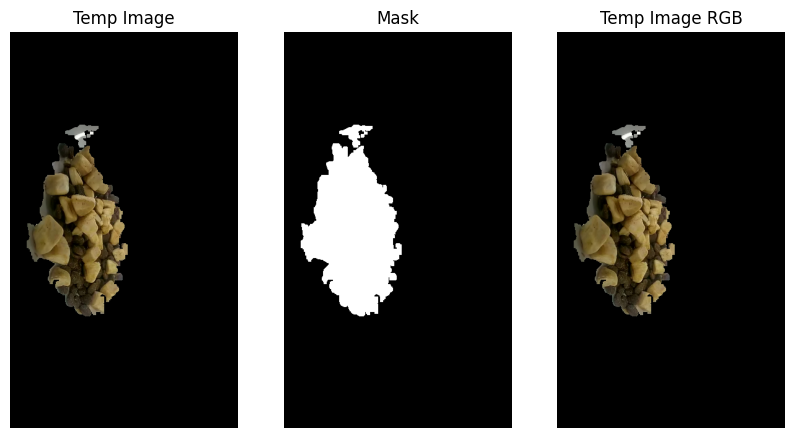

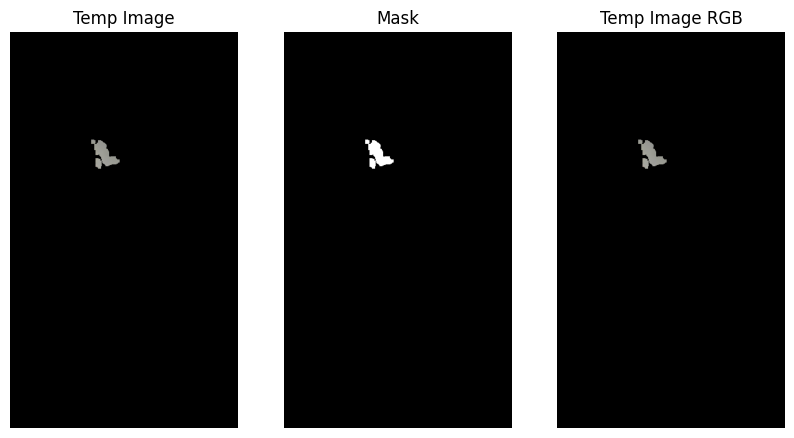

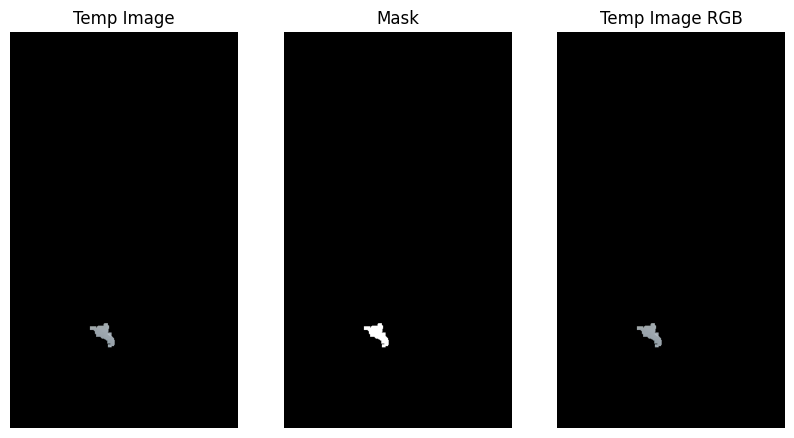

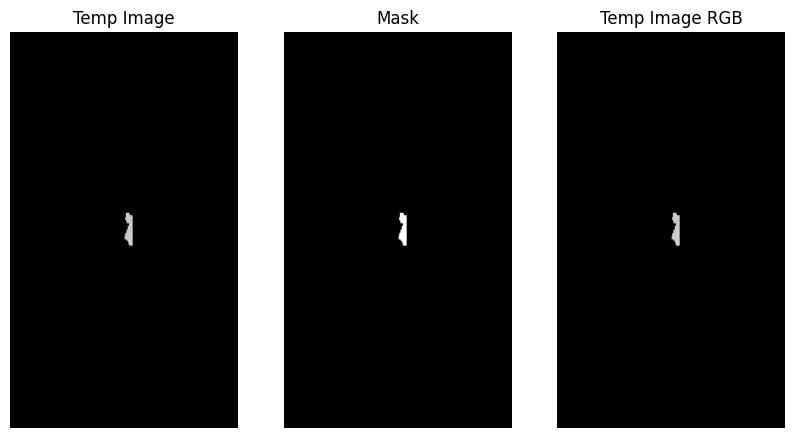

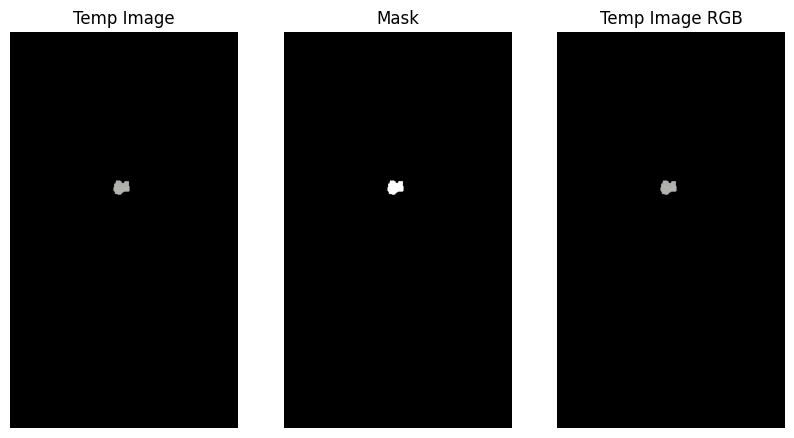

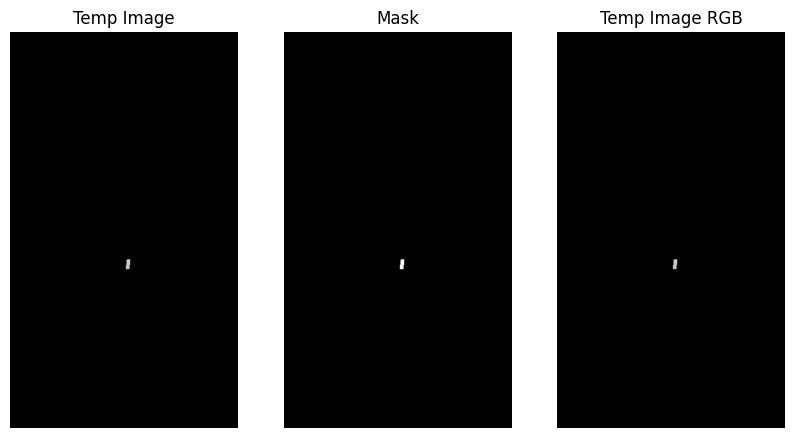

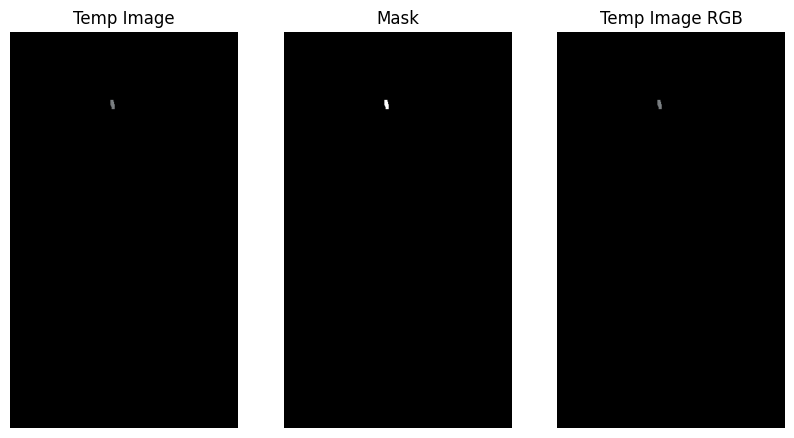

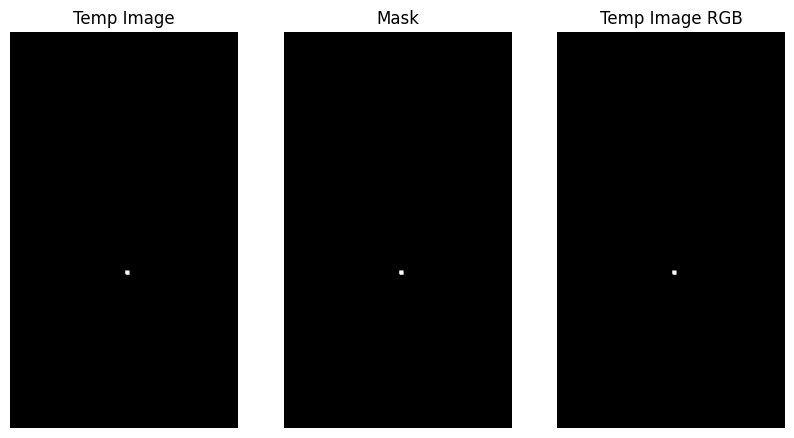

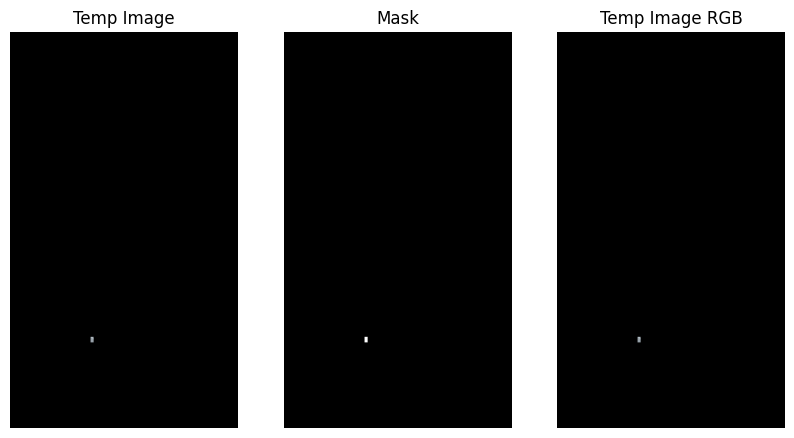

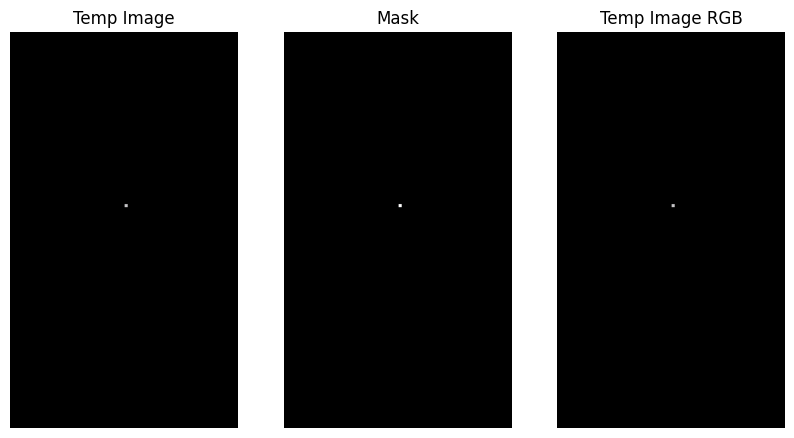

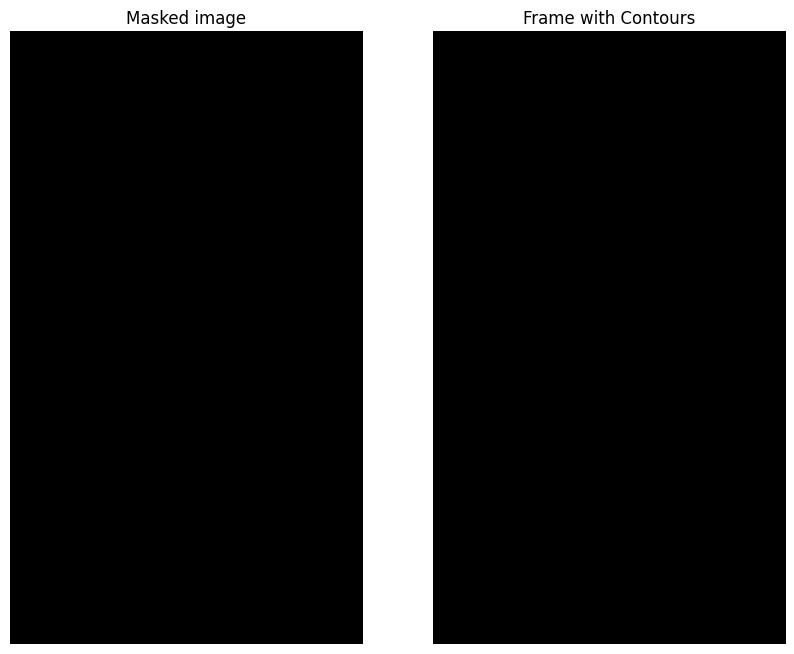

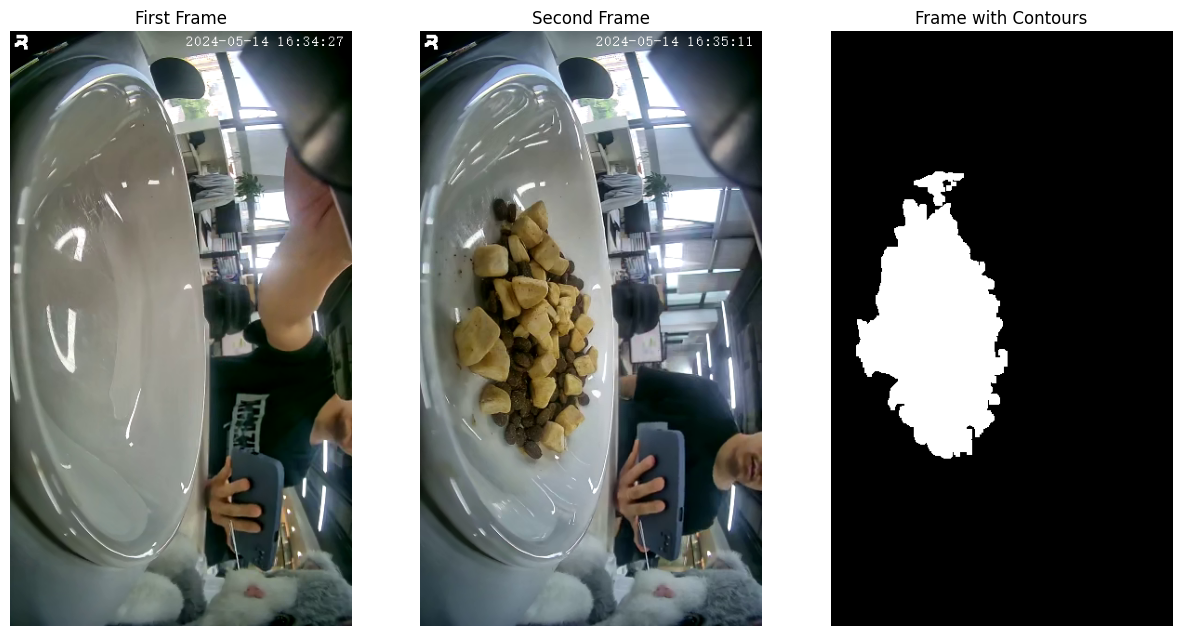

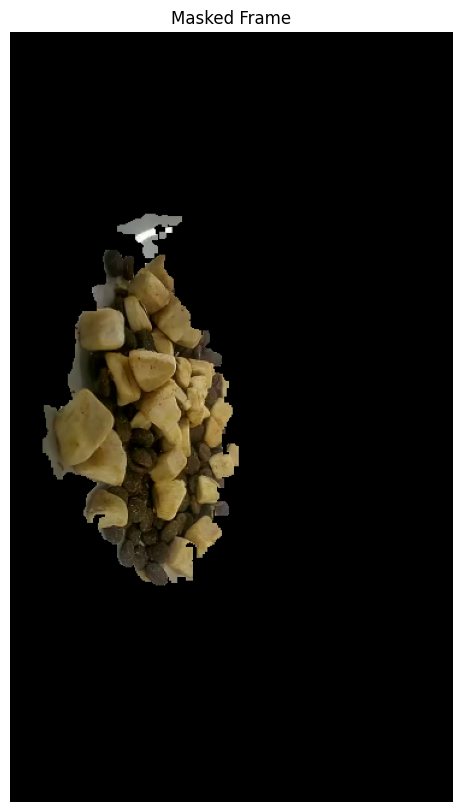

1.741995096206665


In [ ]:

def diff_image(f1, f2, mask=None, debug=False):
    
    temp_f1 = f1.copy()
    temp_f2 = f2.copy()

    def finetune_image(img):
        img = img.astype(np.float32)
        img[:,:,0] = img[:,:,0]*1.2
        img[:,:,1] = img[:,:,1]*1.2
        img[:,:,2] = np.sqrt(img[:,:,2])
        img = np.clip(img, 0, 255).astype(np.uint8)
        return img

    temp_f1 = finetune_image(temp_f1)
    temp_f2 = finetune_image(temp_f2)
    if debug:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(temp_f1)
        plt.axis('off')
        plt.title('Frame 1')
        plt.subplot(1, 2, 2)
        plt.imshow(temp_f2)
        plt.axis('off')
        plt.title('Frame 2')
        plt.show()

    if mask is not None:
        temp_f1 = cv2.bitwise_and(temp_f1, temp_f1, mask=mask)
        temp_f2 = cv2.bitwise_and(temp_f2, temp_f2, mask=mask)


    frame1 = cv2.cvtColor(temp_f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(temp_f2.copy(), cv2.COLOR_BGR2GRAY)
    frame3 = cv2.absdiff(temp_f1[:,:,2], temp_f2[:,:,2])
    frame3 = cv2.equalizeHist(frame3)
    _, thresh = cv2.threshold(frame3, 150, 255, cv2.THRESH_BINARY)
    if debug:
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(f1)
        plt.axis('off')
        plt.title('Frame 1')
        plt.subplot(1, 3, 2)
        plt.imshow(f2)
        plt.axis('off')
        plt.title('Frame 2')
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.show()
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 3, 1)
        plt.imshow(frame3, cmap='gray')
        plt.axis('off')
        plt.title('Frame 3')
        plt.subplot(1, 3, 2)
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')
        plt.title('Thresholded Frame Difference')

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)
    if debug:
        plt.subplot(1, 3, 3)
        plt.imshow(thresh, cmap='gray')
        plt.axis('off')
        plt.title('Thresholded Frame Difference (After Morphology)')
        plt.show()

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        return np.zeros_like(f1)
    # 找到最大连通域
    # 查找前五个最大的轮廓
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    # 将这些轮廓变成mask
    masks = []
    for contour in contours:
        mask = np.zeros(frame1.shape, np.uint8)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        temp_image = cv2.bitwise_and(f2, f2, mask=mask)
        # 统计temp_image的颜色分布
        rgb_hist = []
        for i in range(3):
            rgb_hist.append(cv2.calcHist([temp_image], [i], mask, [8], [0, 256]).astype(np.uint32))
        if debug:
            plt.figure(figsize=(10, 10))
            plt.subplot(1, 3, 1)
            plt.imshow(temp_image)
            plt.axis('off')
            plt.title('Temp Image')
            plt.subplot(1, 3, 2)
            plt.imshow(mask, cmap='gray')
            plt.axis('off')
            plt.title('Mask')
            plt.subplot(1, 3, 3)
            plt.imshow(temp_image)
            plt.axis('off')
            plt.title('Temp Image RGB')
            plt.show()
        if all([rgb_hist[0][i] >= 1.5 * rgb_hist[2][i] and rgb_hist[1][i] >= 1.5 * rgb_hist[2][i] for i in range(3, 8)]):
            masks.append(mask)

    # 合并这些mask
    mask = np.zeros(frame1.shape, np.uint8)
    for m in masks:
        mask = cv2.bitwise_or(mask, m)
    # 使用mask将第二帧抠出来
    masked_frame2 = cv2.bitwise_and(f2, f2, mask=mask)

    # return masked_frame2
    # 显示抠出来的帧
    
    if debug:
        # 显示mask
        plt.figure(figsize=(10, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(masked_frame2 )
        plt.axis('off')
        plt.title('Masked image')
        plt.subplot(1, 2, 2)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Frame with Contours')
        plt.show()
    max_contour = max(contours, key=cv2.contourArea)

    # 将最大连通域转换程mask
    mask = np.zeros(frame1.shape, np.uint8)
    cv2.drawContours(mask, [max_contour], 0, 255, -1)

    # 显示原始帧和带有轮廓的帧
    if debug:
        plt.figure(figsize=(15, 10))
        plt.subplot(1, 3, 1)
        plt.title('First Frame')
        plt.imshow(f1)
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(f2)
        plt.axis('off')
        plt.title('Second Frame')
        plt.subplot(1, 3, 3)
        plt.imshow(mask, cmap='gray')
        plt.axis('off')
        plt.title('Frame with Contours')
        plt.show()


    # 使用mask将第二帧抠出来
    masked_frame = cv2.bitwise_and(f2, f2, mask=mask)
    if debug:
        # 显示抠出来的帧
        plt.figure(figsize=(10, 10))
        plt.imshow(masked_frame)
        plt.axis('off')
        plt.title('Masked Frame')
        plt.show()
    return masked_frame

import time

now = time.time()
mask = cv2.imread('1715675377828.jpg', cv2.IMREAD_GRAYSCALE)
print(mask.shape)
diff_image(frame1, frame2, mask, True)
duration = time.time() - now
# print second
print(duration)

In [39]:
def diff_image_for_video(f1, f2, mask=None):
    
    temp_f1 = f1.copy()
    temp_f2 = f2.copy()

    if mask is not None:
        temp_f1 = cv2.bitwise_and(temp_f1, temp_f1, mask=mask)
        temp_f2 = cv2.bitwise_and(temp_f2, temp_f2, mask=mask)


    frame1 = cv2.cvtColor(temp_f1.copy(), cv2.COLOR_BGR2GRAY)
    frame2 = cv2.cvtColor(temp_f2.copy(), cv2.COLOR_BGR2GRAY)
    
    frame3 = cv2.absdiff(frame1, frame2)

    _, thresh = cv2.threshold(frame3, 20, 255, cv2.THRESH_BINARY)

    # 可选：应用形态学操作以减少噪声
    kernel = np.ones((5, 5), np.uint8)
    thresh = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel)

    # 查找轮廓
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # 找到最大连通域
    # 查找前五个最大的轮廓
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:10]
    # 将这些轮廓变成mask
    masks = []
    for contour in contours:
        mask = np.zeros(frame1.shape, np.uint8)
        cv2.drawContours(mask, [contour], 0, 255, -1)
        temp_image = cv2.bitwise_and(f2, f2, mask=mask)
        # 统计temp_image的颜色分布
        rgb_hist = []
        for i in range(3):
            rgb_hist.append(cv2.calcHist([temp_image], [i], mask, [8], [16, 256]).astype(np.uint32))
        if all([rgb_hist[0][i] >= 1.2 * rgb_hist[2][i] and rgb_hist[1][i] >= 1.2 * rgb_hist[2][i] for i in range(3, 8)]):
            masks.append(mask)

    # 合并这些mask
    mask = np.zeros(frame1.shape, np.uint8)
    for m in masks:
        mask = cv2.bitwise_or(mask, m)
    # 使用mask将第二帧抠出来
    masked_frame2 = cv2.bitwise_and(f2, f2, mask=mask)

    return masked_frame2

In [35]:
final_frames = []
for frame in frames:
    final_frames.append(diff_image(frame1, frame, mask))

h, w, c = final_frames[0].shape
# save frames into one video
fourcc = cv2.VideoWriter_fourcc(*'XVID')
video = cv2.VideoWriter('output3.avi', fourcc, 1.0, (w*2, h))
for ori, dst in zip(frames, final_frames):
    temp = np.zeros((h, w*2, c), dtype=np.uint8)
    temp[:, :w, :] = ori
    temp[:, w:, :] = dst
    temp = cv2.cvtColor(temp, cv2.COLOR_RGB2BGR)
    video.write(temp)
video.release()
    
